# Minplus algebra experiment

This code attempts to learn the 2D mixture prior
$J(x) = \max_{i \in \{1,...,m\}} \{<p_i^{true},x>\}$
assuming we have access to training data $\{y_i, S(y_i)\} = \max_{i \in \{1,...,m\}} \{<p_i^{true},x> - t \theta_i^{true} - \gamma_i^{true}\}$.

## Import modules 

In [56]:
import os
import numpy as np
import torch

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import seaborn as sns

from network import LPN
from lib.utils import cvx
from lib.invert import invert

# set location
MODEL_DIR = "experiments/models/minplus_4_1_3_2D"
os.makedirs(MODEL_DIR, exist_ok=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# set random seeds
np.random.seed(1)
torch.manual_seed(1)

# plotting options
plt.rcParams.update({"text.usetex": False})
sns.set_theme()

## Parameters

In [57]:

# --- Parameters for Sec 4.1.3---
dim_41 = 2  # Example dimension (e.g., 2D, 4D, 8D as in the paper)
m_41 = 4   # Example number of neurons (e.g., 2 or 4 as in the paper)
data_points_41 = 20000 # Example number of data points
iterations_41 = 1000 # Reduced iterations for demonstration
a_41 = 4 # Grid limit for sampling y_j if using uniform
spacing = 500


# LPN model parameters
# Note: The defaults parameters are beta = 10, hidden = 50, layers = 4
beta = 10       # beta of softplus
hidden = 50     # number of hidden units
layers = 4      # number of layers

# optimization algorithm to use for computing the prior (cvx_cg, cvx_gd)
INVERT_MODE = "cvx_gd"

# === Section 4.1: Cases 3 ===

In [58]:
import numpy as np
import matplotlib.pyplot as plt
import torch 

def inner_prod(x, y):
    return np.sum(x * y, axis=1)

def euclid_norm_sq(x):
    return np.sum(x * x, axis=1)

def hjsol_true_case3(y_points, p_true_vectors):
    m = p_true_vectors.shape[0]
    N = y_points.shape[0]
    s_values = np.zeros((N, m))
    theta_true_i = -0.5 * euclid_norm_sq(p_true_vectors)
    for i in range(m):
        s_values[:, i] = inner_prod(y_points, p_true_vectors[i, :]) - theta_true_i[i]
    return np.max(s_values, axis=1)

def prior_true_case3(y_points, p_true_vectors):
    m = p_true_vectors.shape[0]
    N = y_points.shape[0]
    j_values = np.zeros((N, m))
    for i in range(m):
        j_values[:, i] = inner_prod(y_points, p_true_vectors[i, :])
    return np.max(j_values, axis=1)

def cvx_true_case3(y_points, p_true_vectors):
    s_y_1 = hjsol_true_case3(y_points, p_true_vectors)
    psi_y = 0.5 * euclid_norm_sq(y_points) - s_y_1
    return psi_y



# --- Functions for evaluating the learned LPN model (adapted from notebook) ---

def invert_prior(x, model, INVERT_MODE):
    """ 
    This function inverts the learned prior at a set of query points x.
    That is, we compute the points y for which nabla_{y}psi(y) = x, 
    where nabla_{y}psi denotes the gradient of the LPN network.
    
    Args:
        x (np.ndarray): A numpy array of real numbers at which to invert the prior.
        model: The trained LPN model object.
        INVERT_MODE: The method for inverting the LPN network.

    Returns:
        np.ndarray: The (approximate) set of points y for which nabla_{y}psi(y) = x.
    """
    y = invert(x,model,INVERT_MODE)
    return y

def evaluate_learned_prior_case3(x_eval_points, y_inverted_points, model):
    """ 
    This function evaluates the learned prior J_est(x_eval_points) using the LPN.
    It uses y_inverted_points where x_eval_points = nabla_psi(y_inverted_points).
    The formula used is J_est(x) = <x, y> - 0.5 * ||x||^2 - psi(y)
    
    Args:
        x_eval_points (np.ndarray): N x dim array of points at which to estimate the prior J(x).
        y_inverted_points (np.ndarray): N x dim_psi array of points y such that x_eval_points = nabla_psi(y_inverted_points).
                                       dim_psi is the input dimension to the LPN.
        model: The trained LPN model object (e.g., a torch.nn.Module).

    Returns:
        np.ndarray: N-dimensional array of estimated prior values J_est(x_eval_points).
    """
    # Ensure y_inverted_points is a torch tensor for model input
    try:
        y_tensor = torch.from_numpy(y_inverted_points).float().to(device)
        psi_of_y_inverted = model.scalar(y_tensor).squeeze(1).detach().cpu().numpy()
    except NameError: # device might not be defined if torch is not fully set up
        print("Warning: 'device' not defined. Assuming CPU for evaluate_learned_prior.")
        y_tensor = torch.from_numpy(y_inverted_points).float()
        psi_of_y_inverted = model.scalar(y_tensor).squeeze(1).detach().numpy()
    

    # Formula: J_est(x) = <x,y> - 0.5*||x||^2 - psi(y)
    # Changed to 0.5 * euclid_norm_sq(x) which is 0.5 * ||x||^2.
    prior_est = inner_prod(x_eval_points, y_inverted_points) - 0.5 * euclid_norm_sq(x_eval_points) - psi_of_y_inverted
    
    return prior_est

# --- Plotting tools (Modified) ---

def compute_square_cross_sections(a, spacing, dim):
    ''' Compute the cross sections (xi,0,...,0) and (0,xi,0,...,0) 
    on the grid [-a,a]^{dim} along the first and second dimensions.
    '''
    xi = np.linspace(-a, a, spacing)
    grid = np.zeros((xi.size, dim))
    x1_0_points = np.copy(grid)
    x1_0_points[:, 0] = xi
    
    x2_0_points = np.copy(grid)
    if dim > 1: # Ensure we don't try to access index 1 if dim is 1
        x2_0_points[:, 1] = xi
    elif dim == 1: # For 1D, x2_0_points is not really a "second axis" cross-section
        x2_0_points = x1_0_points.copy() # Or handle as appropriate for 1D plots

    return xi, x1_0_points, x2_0_points


def cross_sections_plots_case3(model, a, spacing, p_true_vectors, INVERT_MODE, dim):
    ''' 
    Compare the true functions for Case 3 vs the LPN model
    on a square grid [-a,a]^{dim} by overlaying their cross sections 
    along the first and (if dim > 1) second axes.

    Args:
        model: The trained LPN model object.
        a: Measure of the grid [-a,a]^{dim}.
        spacing: Number of points in the interval [-a,a].
        p_true_vectors (np.ndarray): m x dim array of true p_i vectors for Case 3.
        INVERT_MODE: The method for inverting the LPN network.
        dim: Spatial dimension of the problem.
    '''
    xi, x1_0_points, x2_0_points = compute_square_cross_sections(a, spacing, dim)

    # Compute the true psi (cvx_true) and prior (prior_true) for Case 3
    x1_0_psi_true = cvx_true_case3(x1_0_points, p_true_vectors)
    x1_0_J_true = prior_true_case3(x1_0_points, p_true_vectors)

    if dim > 1:
        x2_0_psi_true = cvx_true_case3(x2_0_points, p_true_vectors)
        x2_0_J_true = prior_true_case3(x2_0_points, p_true_vectors)
    else: # For 1D, use the same points for "second" axis plot or omit
        x2_0_psi_true = x1_0_psi_true 
        x2_0_J_true = x1_0_J_true


    # Compute the learned psi and prior from the LPN model
    x1_0_psi_est = cvx(x1_0_points, model) # LPN directly learns/outputs psi
    y1_inverted = invert_prior(x1_0_points, model, INVERT_MODE)
    x1_0_J_est = evaluate_learned_prior_case3(x1_0_points, y1_inverted, model)

    if dim > 1:
        x2_0_psi_est = cvx(x2_0_points, model)
        y2_inverted = invert_prior(x2_0_points, model, INVERT_MODE)
        x2_0_J_est = evaluate_learned_prior_case3(x2_0_points, y2_inverted, model)
    else:
        x2_0_psi_est = x1_0_psi_est
        x2_0_J_est = x1_0_J_est


    # Plot cross sections of the convex function psi(y)
    plt.figure() # Use plt.figure() for new plot
    plt.plot(xi, x1_0_psi_est, "-", ms=5, label="LPN (Learned $\psi$)")
    plt.plot(xi, x1_0_psi_true, "--", ms=5, label="True $\psi$ (Case 3)") # Changed to dashed for true
    plt.grid(True) # Use boolean for grid
    plt.title(f"Cross sections ($\psi(y_1,0,...)$) - Dim {dim}, Case 3")
    plt.xlabel('$y_1$')
    plt.ylabel('$\psi(y_1,0,...)$')
    plt.legend()
    plt.show()

    if dim > 1:
        plt.figure()
        plt.plot(xi, x2_0_psi_est, "-", ms=5, label="LPN (Learned $\psi$)")
        plt.plot(xi, x2_0_psi_true, "--", ms=5, label="True $\psi$ (Case 3)")
        plt.grid(True)
        plt.title(f"Cross sections ($\psi(0,y_2,0,...)$) - Dim {dim}, Case 3")
        plt.xlabel('$y_2$')
        plt.ylabel('$\psi(0,y_2,0,...)$')
        plt.legend()
        plt.show()

    # Plot cross sections of the prior function J(x)
    # Note: The x-axis here represents the components of x_eval_points,
    # which are the same as y_points for these cross-sections.
    plt.figure()
    plt.plot(xi, x1_0_J_est, "-", label="LPN (Learned $J$)")
    plt.plot(xi, x1_0_J_true, "--", label="True $J$ (Case 3)")
    plt.grid(True)
    plt.title(f"Cross sections ($J(x_1,0,...)$) - Dim {dim}, Case 3")
    plt.xlabel('$x_1$')
    plt.ylabel('$J(x_1,0,...)$')
    plt.legend()
    plt.show()

    if dim > 1:
        plt.figure()
        plt.plot(xi, x2_0_J_est, "-", label="LPN (Learned $J$)")
        plt.plot(xi, x2_0_J_true, "--", label="True $J$ (Case 3)")
        plt.grid(True)
        plt.title(f"Cross sections ($J(0,x_2,0,...)$) - Dim {dim}, Case 3")
        plt.xlabel('$x_2$')
        plt.ylabel('$J(0,x_2,0,...)$')
        plt.legend()
        plt.show()


def plot_all_case3(model, a, spacing, p_true_vectors, INVERT_MODE, dim):
    """
    Wrapper to plot cross sections for Case 3.
    """
    print(f"\n--- Plotting Cross Sections for Case 3 (Dim={dim}) ---")
    cross_sections_plots_case3(model, a, spacing, p_true_vectors, INVERT_MODE, dim)

In [59]:
# Helper functions

print("\n--- Reproducing Section 4.1: Cases 3 ---")

def exp_func(x, gamma):
    ''' Proximal matching loss -- x |-> 1 - exp(-(||x||_{2}^{2}/gamma)^{2})
        for training learned proximal networks.
    '''
    return -torch.exp(-((torch.linalg.vector_norm(x, ord = 2, dim = 1)/ gamma) ** 2)) + 1.0

def euclid_norm_sq(x):
    # Assuming x is N x dim numpy array
    return np.sum(x*x, axis=1)

def S_true_sec41(x, t, p_true, theta_true, gamma_true):
    """ Calculates the true solution S(x, t) for Section 4.1 cases. """
    # x: N x dim numpy array
    # t: scalar time
    # p_true: m x dim numpy array
    # theta_true: m x 1 numpy array
    # gamma_true: m x 1 numpy array
    m = p_true.shape[0]
    N = x.shape[0]
    vals = np.zeros((N, m))
    for i in range(m):
        vals[:, i] = inner_prod(x, p_true[i, :]) - t * theta_true[i] - gamma_true[i]
    return np.max(vals, axis=1)

# --- Generate p_true (randomly in [-1, 1)^n) ---
p_true_41 = np.random.uniform(-1, 1, (m_41, dim_41))
print(f"Generated p_true_41 (shape {p_true_41.shape})")


--- Reproducing Section 4.1: Cases 3 ---
Generated p_true_41 (shape (4, 2))


# --- Generate Training Data (using Moreau envelope target as per notebook) ---

In [60]:
# --- Generate Training Data (using Moreau envelope target as per notebook) ---
# Sample y_j points (uniformly on [-a, a]^n grid)
y_j_41= np.zeros((dim_41,data_points_41))

if(dim_41>1):
    for k in range(0,dim_41):
        y_j_41[k] = np.random.uniform(-a_41,a_41,data_points_41)
else:
    y_j_41 = np.random.uniform(-a_41,a_41,data_points_41)

#y_j_41 = np.random.uniform(-a_41, a_41, data_points_41)
y_j_41 = y_j_41.reshape(data_points_41,dim_41)


theta_true_c3 = -0.5 * euclid_norm_sq(p_true_41)
gamma_true_c3 = np.zeros(m_41)

# Calculate S(y_j, t=1) for Case 3
S_samples_c3 = S_true_sec41(y_j_41, 1.0, p_true_41, theta_true_c3, gamma_true_c3)
# Calculate target psi(y_j) = 0.5*||y_j||^2 - S(y_j, 1)
cvx_samples_c3 = 0.5 * euclid_norm_sq(y_j_41) - S_samples_c3
cvx_samples_c3 = cvx_samples_c3.reshape(-1, 1) # Reshape for loss calculation
# Recast the samples as tensors
y_j_41 = torch.from_numpy(y_j_41).float()
cvx_samples_c3 = torch.from_numpy(cvx_samples_c3).float()

## Training function

In [61]:
def single_iteration(i, data_points, lpn_model, optimizer,input,cvx_samples,loss_type, gamma_loss=None):
    # Compute the convex function from the input.
    cvx_out = lpn_model.scalar(input)

    # Calculate the loss function
    if loss_type == 2:
        loss = (cvx_out - cvx_samples).pow(2).sum() / data_points # MSE loss
    elif loss_type == 1:
        loss = (cvx_out - cvx_samples).abs().sum() / data_points    # MAE loss
    elif loss_type == 0:
        loss = exp_func(cvx_out - cvx_samples, gamma_loss).mean()   # proximal matching loss
    else:
        raise ValueError("loss_type must be 0, 1, or 2")


    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    lpn_model.wclip()

    # monitor
    # loss_lstar = exp_func(out - target, 0.1).mean()

    if not i % 500:
        print("iteration", i, "loss", loss.item()) #, "loss_lstar", loss_lstar.item())

# Train

L2 loss -- Train

In [62]:

# --- Train LPN for Case 3 ---
print("--- Training LPN for Case 3 ---")
lpn_model_c3 = LPN(in_dim=dim_41, hidden=100, layers=5, beta=10).to(device)
optimizer_c3 = torch.optim.Adam(lpn_model_c3.parameters(), lr=1e-4)

for i in range(iterations_41):
     single_iteration(i, data_points_41, lpn_model_c3, optimizer_c3, y_j_41,cvx_samples_c3,loss_type=2,gamma_loss=None) # Using MSE

for g in optimizer_c3.param_groups:
    g["lr"] = 1e-4
for i in range(30000):
    single_iteration(i, data_points_41, lpn_model_c3, optimizer_c3, y_j_41,cvx_samples_c3,loss_type=2,gamma_loss=None)

# Save the model for Case 3
# save the model
torch.save(lpn_model_c3.state_dict(), os.path.join(MODEL_DIR, "Case3_l2.pth"))

--- Training LPN for Case 3 ---
iteration 0 loss 20.821657180786133
iteration 500 loss 304.7661437988281
iteration 0 loss 69.5416259765625
iteration 500 loss 24.62258529663086
iteration 1000 loss 10.534080505371094
iteration 1500 loss 5.2619500160217285
iteration 2000 loss 3.1668200492858887
iteration 2500 loss 2.335294008255005
iteration 3000 loss 2.0156922340393066
iteration 3500 loss 1.8908226490020752
iteration 4000 loss 1.8228871822357178
iteration 4500 loss 1.75713312625885
iteration 5000 loss 1.673702359199524
iteration 5500 loss 1.5651423931121826
iteration 6000 loss 1.4274321794509888
iteration 6500 loss 1.2566267251968384
iteration 7000 loss 1.0484225749969482
iteration 7500 loss 0.800911009311676
iteration 8000 loss 0.5250317454338074
iteration 8500 loss 0.27215054631233215
iteration 9000 loss 0.12434691190719604
iteration 9500 loss 0.06739840656518936
iteration 10000 loss 0.04384400323033333
iteration 10500 loss 0.03037334978580475
iteration 11000 loss 0.021618904545903206


L2 loss -- Plot


--- Plotting Cross Sections for Case 3 (Dim=2) ---
loss -31.055320739746094
loss -87.32868194580078
loss -125.27000427246094
loss -150.5705108642578
loss -170.82272338867188
loss -187.58987426757812
loss -199.93365478515625
loss -208.06231689453125
loss -213.2154541015625
loss -216.4495849609375
loss -218.42868041992188
loss -219.56353759765625
loss -220.1456298828125
loss -220.4007568359375
loss -220.49365234375
loss -220.52130126953125
loss -220.52792358398438
loss -220.5291290283203
loss -220.52928161621094
loss -220.52931213378906
loss -220.52931213378906
loss -220.52928161621094
loss -220.52931213378906
loss -220.529296875
loss -220.52931213378906
loss -220.52928161621094
loss -220.52931213378906
loss -220.52928161621094
loss -220.52928161621094
loss -220.52931213378906
loss -220.52932739257812
loss -220.52931213378906
loss -220.52931213378906
loss -220.52931213378906
loss -220.52931213378906
loss -220.52928161621094
loss -220.52931213378906
loss -220.529296875
loss -220.52929687

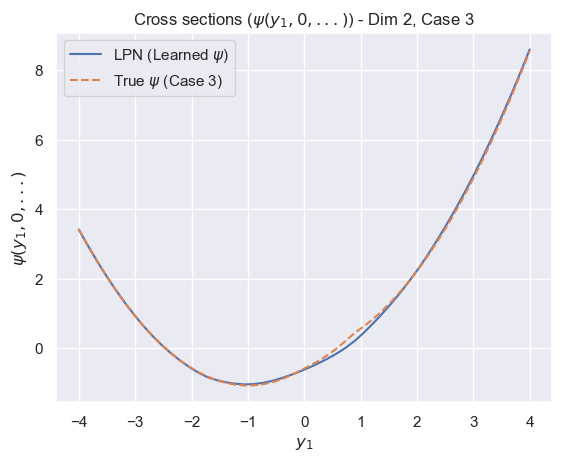

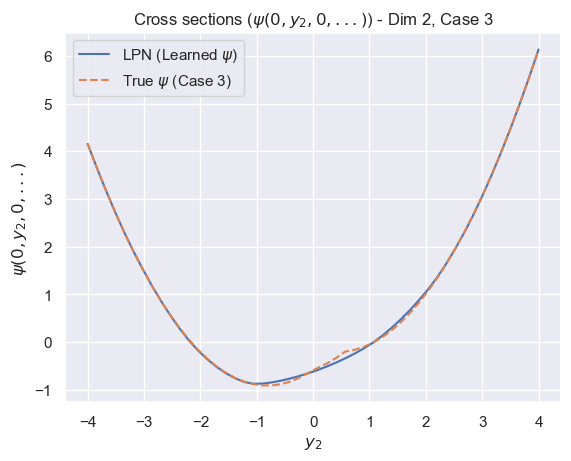

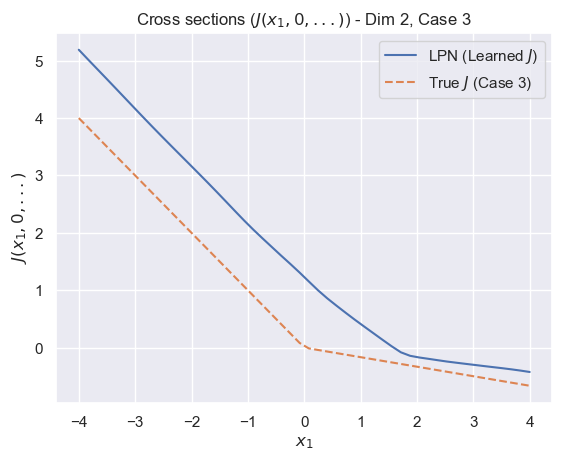

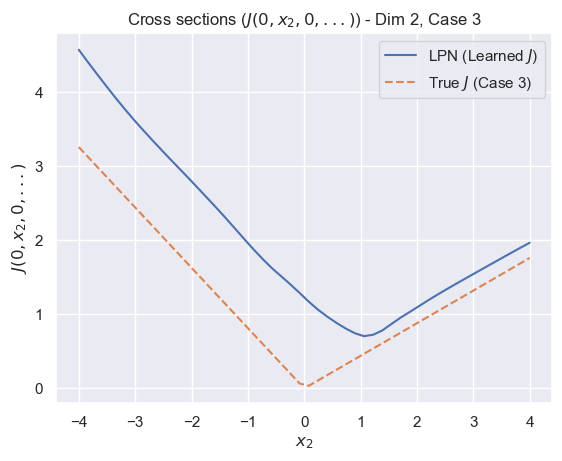

In [63]:
plot_all_case3(lpn_model_c3, a_41, spacing, p_true_41, INVERT_MODE, dim_41)

L1 loss -- Train

In [64]:
# --- Train LPN for Case 3 ---
print("--- Training LPN for Case 3 ---")
lpn_model_c3 = LPN(in_dim=dim_41, hidden=50, layers=4, beta=10).to(device)
optimizer_c3 = torch.optim.Adam(lpn_model_c3.parameters(), lr=1e-3)

for i in range(iterations_41):
     single_iteration(i, data_points_41, lpn_model_c3, optimizer_c3, y_j_41,cvx_samples_c3,loss_type=1,gamma_loss=None)

for g in optimizer_c3.param_groups:
    g["lr"] = 1e-4
for i in range(30000):
    single_iteration(i, data_points_41, lpn_model_c3, optimizer_c3, y_j_41,cvx_samples_c3,loss_type=1,gamma_loss=None)

# Save the model for Case 3
# save the model
torch.save(lpn_model_c3.state_dict(), os.path.join(MODEL_DIR, "Case3_l1.pth"))

--- Training LPN for Case 3 ---
iteration 0 loss 3.9920592308044434
iteration 500 loss 0.06382966786623001
iteration 0 loss 0.04153169319033623
iteration 500 loss 0.03676034137606621
iteration 1000 loss 0.03485047444701195
iteration 1500 loss 0.033123649656772614
iteration 2000 loss 0.03156116604804993
iteration 2500 loss 0.03017541952431202
iteration 3000 loss 0.02899063192307949
iteration 3500 loss 0.0276915542781353
iteration 4000 loss 0.02712802216410637
iteration 4500 loss 0.026563705876469612
iteration 5000 loss 0.025914737954735756
iteration 5500 loss 0.02545858919620514
iteration 6000 loss 0.025054989382624626
iteration 6500 loss 0.025019673630595207
iteration 7000 loss 0.02436533011496067
iteration 7500 loss 0.02410753071308136
iteration 8000 loss 0.02359461598098278
iteration 8500 loss 0.023776613175868988
iteration 9000 loss 0.023403985425829887
iteration 9500 loss 0.023185063153505325
iteration 10000 loss 0.02316402457654476
iteration 10500 loss 0.023246124386787415
iterati

L1 loss -- Plot


--- Plotting Cross Sections for Case 3 (Dim=2) ---
loss -33.2758674621582
loss -87.66651916503906
loss -126.21126556396484
loss -152.26983642578125
loss -172.45285034179688
loss -188.86773681640625
loss -200.84547424316406
loss -208.6888427734375
loss -213.805419921875
loss -217.04647827148438
loss -218.9574432373047
loss -220.14288330078125
loss -220.92379760742188
loss -221.41619873046875
loss -221.71243286132812
loss -221.89833068847656
loss -222.0244598388672
loss -222.11354064941406
loss -222.1770782470703
loss -222.2220458984375
loss -222.25338745117188
loss -222.27548217773438
loss -222.29049682617188
loss -222.29959106445312
loss -222.3043212890625
loss -222.3065185546875
loss -222.307373046875
loss -222.30767822265625
loss -222.30776977539062
loss -222.30776977539062
loss -222.30780029296875
loss -222.30776977539062
loss -222.30780029296875
loss -222.30776977539062
loss -222.30776977539062
loss -222.30776977539062
loss -222.30776977539062
loss -222.30776977539062
loss -222.30

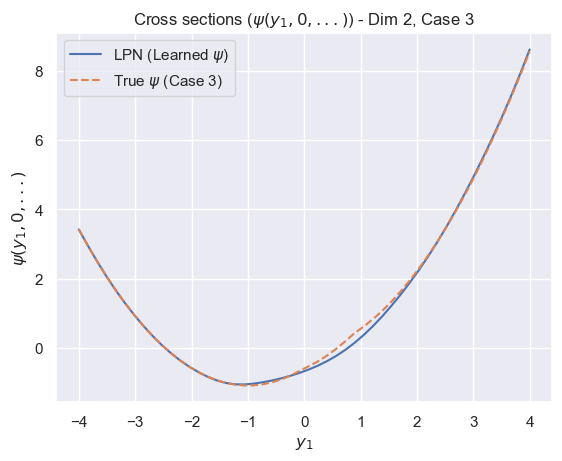

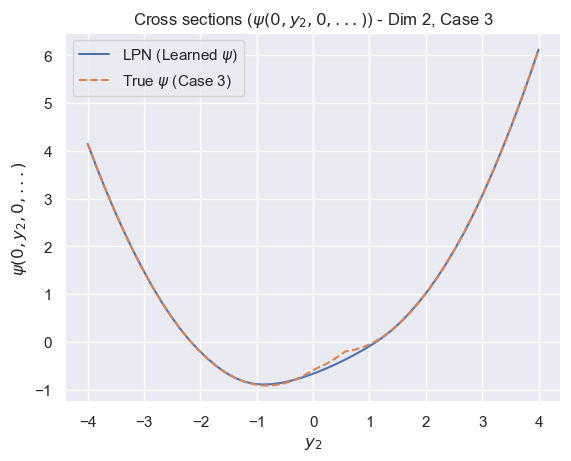

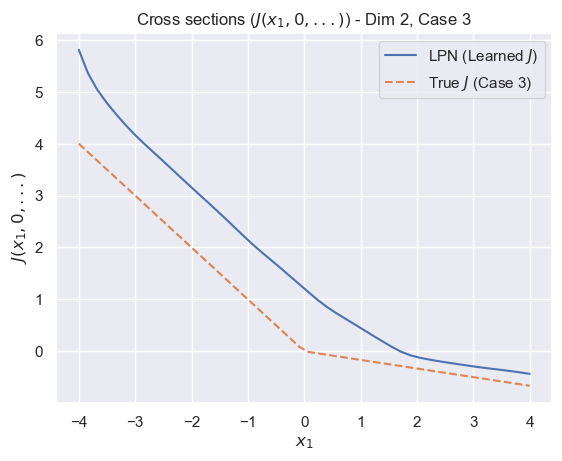

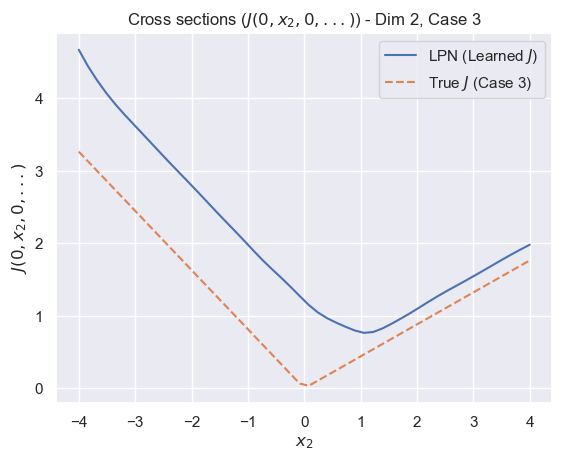

In [65]:
plot_all_case3(lpn_model_c3, a_41, spacing, p_true_41, INVERT_MODE, dim_41)

Proximal matching loss.
We perform proximal matching loss with a decreasing sequence of gamma parameters.

gamma = 20 -- Train

In [66]:
# lpn_model = LPN(in_dim=dim, hidden=hidden, layers=layers, beta=beta).to(device)
# optimizer = torch.optim.Adam(lpn_model.parameters(), lr=1e-3)

# loss_type = 0
# gamma_loss = 20

# # set learning rate
# for g in optimizer.param_groups:
#     g["lr"] = 1e-4

# for i in range(3000):
#     single_iteration(i, data_points, lpn_model, optimizer, loss_type, gamma_loss)

# for g in optimizer.param_groups:
#     g["lr"] = 1e-5

# for i in range(3000):
#     single_iteration(i, data_points, lpn_model, optimizer, loss_type, gamma_loss)

# torch.save(lpn_model.state_dict(), os.path.join(MODEL_DIR, f"l_{gamma_loss}.pth"))

gamma = 20 -- Plot

In [67]:
# plot_all(lpn_model,a,spacing,mu1,mu2,sigma1,sigma2,INVERT_MODE,dim)

gamma = 12.5 -- Train

In [68]:
# gamma_loss = 12.5

# for g in optimizer.param_groups:
#     g["lr"] = 1e-5

# for i in range(6000):
#     single_iteration(i, data_points, lpn_model, optimizer, loss_type, gamma_loss)

# torch.save(lpn_model.state_dict(), os.path.join(MODEL_DIR, f"l_{gamma_loss}.pth"))

gamma = 12.5 -- Plot

In [69]:
# plot_all(lpn_model,a,spacing,mu1,mu2,sigma1,sigma2,INVERT_MODE,dim)

gamma = 10 -- Train

In [70]:
# gamma_loss = 10

# for g in optimizer.param_groups:
#     g["lr"] = 1e-5

# for i in range(10000):
#     single_iteration(i, data_points, lpn_model, optimizer, loss_type, gamma_loss)

# torch.save(lpn_model.state_dict(), os.path.join(MODEL_DIR, f"l_{gamma_loss}.pth"))

gamma = 10 -- Plot

In [71]:
# plot_all(lpn_model,a,spacing,mu1,mu2,sigma1,sigma2,INVERT_MODE,dim)